In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
import scipy.stats as sp
import pickle

np.random.seed(111)

print('TensorFlow version:', tf.__version__)
print('Is Executing Eagerly?', tf.executing_eagerly())

Using TensorFlow backend.


TensorFlow version: 2.2.0-rc3
Is Executing Eagerly? True


# **Task 1:**

We've built models to the same specification as those given in the project brief using the Keras sequential API.

In our experiments we've found that, for models of the same specification, those built with the Keras sequential API outperform models built by alternative methods. 

The only explaination we can offer is that Keras is a well optimised library or, alternatively, that the models given in the project brief are built in a convoluted manner and thus perform poorly.

## **Preprocessing**

As we've redefined our models there's no need to flatten our inputs at this stage. We add a flatten layer and a reshape layer to our dense autoencoder as necessary.

Thus we can use the same training data for all our models.

We dont know of any downside to this.

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
w = x_train.shape[1]
h = x_train.shape[2]
d = x_train.shape[3]

##**Dense, multi-layer model (Sequential API)**

In [0]:
dense_encoder = keras.Sequential([
                                  keras.layers.Flatten(input_shape = (w, h, d)),
                                  keras.layers.Dense(128, activation = 'relu'),
                                  keras.layers.Dense(128, activation = 'relu')
])

dense_decoder = keras.Sequential([
                                  keras.layers.Dense(128, activation = 'relu'),
                                  keras.layers.Dense(w*h, activation = 'relu'),
                                  keras.layers.Reshape((w, h, d))
])

dense_autoencoder = keras.Sequential([
                                      dense_encoder,
                                      dense_decoder
])


dense_encoder.summary()
dense_decoder.summary()
dense_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
Total params: 116,992
Trainable params: 116,992
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
____________________________

## **CNN basic model (Sequential API)**

In [0]:
cnn_basic_encoder = tf.keras.Sequential([   
                                         tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(w, h, d)),
                                         tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                         tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same'),
                                         tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                         tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same'),
                                         tf.keras.layers.MaxPooling2D((2,2), padding='same'),                                                                       

])

cnn_basic_decoder = tf.keras.Sequential([
                                         tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same'),
                                         tf.keras.layers.UpSampling2D((2,2)),
                                         tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same'),
                                         tf.keras.layers.UpSampling2D((2,2)),
                                         tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
                                         tf.keras.layers.UpSampling2D((2,2)),                                

                                         tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'),                                         
])

cnn_basic_autoencoder = tf.keras.Sequential([
                                             cnn_basic_encoder,
                                             cnn_basic_decoder
])

cnn_basic_encoder.summary()
cnn_basic_decoder.summary()
cnn_basic_autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
____________________________________________________

## **CNN complex model**

This model has less layers than the basic CNN; but more trainable parameters.

In [0]:
cnn_complex_encoder = keras.Sequential([
                                        tf.keras.layers.Conv2D(64, (4,4), activation='relu', padding='same', input_shape=(w, h, d)),
                                        tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                        tf.keras.layers.Conv2D(32, (2,2), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2,2), padding='same'),                                         
])

cnn_complex_decoder = keras.Sequential([
                                        tf.keras.layers.Conv2D(32, (2,2), activation='relu', padding='same'),
                                        tf.keras.layers.UpSampling2D((2,2)),
                                        tf.keras.layers.Conv2D(64, (4,4), activation='relu', padding='same'),
                                        tf.keras.layers.UpSampling2D((2,2)),                                
                                        tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

cnn_complex_autoencoder = keras.Sequential([
                                            cnn_complex_encoder,
                                            cnn_complex_decoder
                                        
])

cnn_complex_encoder.summary()
cnn_complex_decoder.summary()
cnn_complex_autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 9,312
Trainable params: 9,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 7, 7, 32)          4128      
______________________________

## **Training**

###**Compilation and training**

In [0]:
dense_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

In [0]:
cnn_basic_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ['accuracy'])

In [0]:
cnn_complex_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ['accuracy'])

In [0]:
dense_autoencoder_history = dense_autoencoder.fit(x_train, x_train, batch_size=256, epochs=20, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0302 - accuracy: 0.8093 - val_loss: 0.0148 - val_accuracy: 0.8132
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0130 - accuracy: 0.8145 - val_loss: 0.0114 - val_accuracy: 0.8138
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 0.8149 - val_loss: 0.0102 - val_accuracy: 0.8140
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0100 - accuracy: 0.8150 - val_loss: 0.0095 - val_accuracy: 0.8141
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0093 - accuracy: 0.8151 - val_loss: 0.0090 - val_accuracy: 0.8141
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0089 - accuracy: 0.8151 - val_loss: 0.0086 - val_accuracy: 0.8141
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0086 - accuracy: 0.8151 - val_loss: 0.0084 - val_accuracy: 0.8142
Epoch 

In [0]:
cnn_basic_autoencoder_history = cnn_basic_autoencoder.fit(x_train, x_train, batch_size=128, epochs=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 3s 7ms/step - loss: 0.6999 - accuracy: 0.0735 - val_loss: 0.6985 - val_accuracy: 0.0972
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.6972 - accuracy: 0.1364 - val_loss: 0.6960 - val_accuracy: 0.1912
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.6949 - accuracy: 0.2775 - val_loss: 0.6938 - val_accuracy: 0.3799
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.6927 - accuracy: 0.4946 - val_loss: 0.6916 - val_accuracy: 0.6053
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.6903 - accuracy: 0.6945 - val_loss: 0.6889 - val_accuracy: 0.7616
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.6869 - accuracy: 0.7922 - val_loss: 0.6846 - val_accuracy: 0.8051
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.6807 - accuracy: 0.8084 - val_loss: 0.6760 - val_accuracy: 0.8072
Epoch 

In [0]:
cnn_complex_autoencoder_history = cnn_complex_autoencoder.fit(x_train, x_train, batch_size=128, epochs=100, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/100
469/469 [==============================] - 4s 9ms/step - loss: 0.6905 - accuracy: 0.4778 - val_loss: 0.6814 - val_accuracy: 0.6847
Epoch 2/100
469/469 [==============================] - 4s 9ms/step - loss: 0.6683 - accuracy: 0.7621 - val_loss: 0.6522 - val_accuracy: 0.8024
Epoch 3/100
469/469 [==============================] - 4s 9ms/step - loss: 0.6256 - accuracy: 0.8080 - val_loss: 0.5959 - val_accuracy: 0.8072
Epoch 4/100
469/469 [==============================] - 4s 9ms/step - loss: 0.5671 - accuracy: 0.8088 - val_loss: 0.5489 - val_accuracy: 0.8072
Epoch 5/100
469/469 [==============================] - 4s 9ms/step - loss: 0.5341 - accuracy: 0.8088 - val_loss: 0.5275 - val_accuracy: 0.8072
Epoch 6/100
469/469 [==============================] - 4s 9ms/step - loss: 0.5151 - accuracy: 0.8088 - val_loss: 0.5101 - val_accuracy: 0.8072
Epoch 7/100
469/469 [==============================] - 4s 9ms/step - loss: 0.4976 - accuracy: 0.8088 - val_loss: 0.4922 - val_accuracy: 0.8072

### **Checkpoint**

In [0]:
path = '/content/drive/My Drive/cs6421_final_assignment/'

In [0]:
dense_autoencoder.save(path + 'dense_autoencoder')
cnn_basic_autoencoder.save(path + 'cnn_basic_autoencoder')
cnn_complex_autoencoder.save(path + 'cnn_complex_autoencoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/dense_autoencoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_basic_autoencoder/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_complex_autoencoder/assets


In [0]:
with open(path + 'dense_autoencoder_history', 'wb') as save:
  pickle.dump(dense_autoencoder_history.history, save)

with open(path + 'cnn_basic_autoencoder_history', 'wb') as save:
  pickle.dump(cnn_basic_autoencoder_history.history, save)

with open(path + 'cnn_complex_autoencoder_history', 'wb') as save:
  pickle.dump(cnn_complex_autoencoder_history.history, save)

In [0]:
dense_autoencoder = keras.models.load_model(path + 'dense_autoencoder')
cnn_basic_autoencoder = keras.models.load_model(path + 'cnn_basic_autoencoder')
cnn_complex_autoencoder = keras.models.load_model(path + 'cnn_complex_autoencoder')

In [0]:
dense_pickle = open(path + 'dense_autoencoder_history', 'rb')
cnn_basic_pickle = open(path + 'cnn_basic_autoencoder_history', 'rb')
cnn_complex_pickle = open(path + 'cnn_complex_autoencoder_history', 'rb')

dense_autoencoder_history = pickle.load(dense_pickle)
cnn_basic_autoencoder_history = pickle.load(cnn_basic_pickle)
cnn_complex_autoencoder_history = pickle.load(cnn_complex_pickle)

dense_pickle.close()
cnn_basic_pickle.close()
cnn_complex_pickle.close()

##**Results and Discussion**

### **Visualisation**

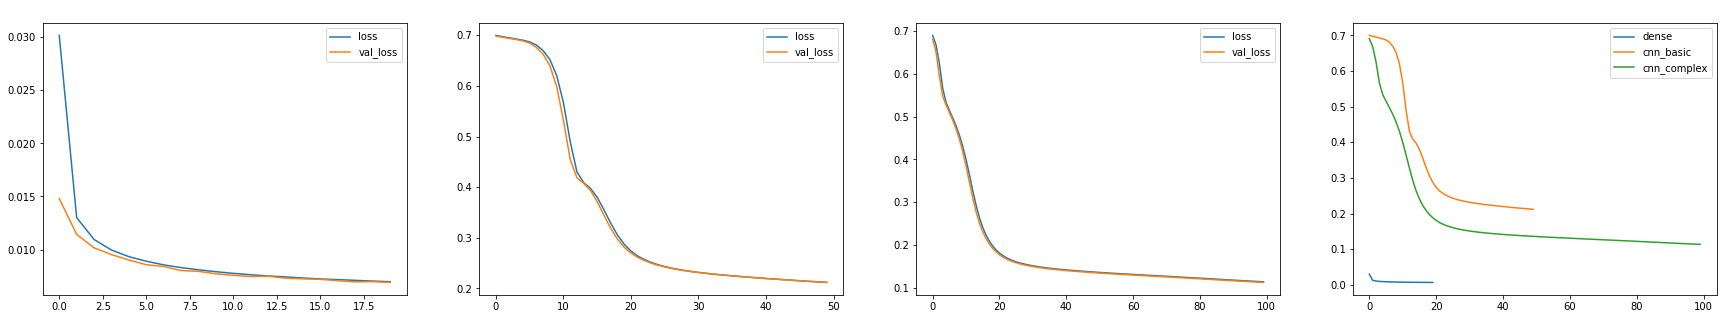

In [0]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
ax[0].plot(range(20), dense_autoencoder_history['loss'], label = 'loss')
ax[0].plot(range(20), dense_autoencoder_history['val_loss'], label = 'val_loss')
ax[0].set_title('dense_autoencoder', color = 'white')
ax[0].legend()

ax[1].plot(range(50), cnn_basic_autoencoder_history['loss'], label = 'loss')
ax[1].plot(range(50), cnn_basic_autoencoder_history['val_loss'], label = 'val_loss')
ax[1].set_title('cnn_basic_autoencoder', color = 'white')
ax[1].legend()

ax[2].plot(range(100), cnn_complex_autoencoder_history['loss'], label = 'loss')
ax[2].plot(range(100), cnn_complex_autoencoder_history['val_loss'], label = 'val_loss')
ax[2].set_title('cnn_complex_autoencoder', color = 'white')
ax[2].legend()

ax[3].plot(range(20), dense_autoencoder_history['loss'], label = 'dense')
ax[3].plot(range(50), cnn_basic_autoencoder_history['loss'], label = 'cnn_basic')
ax[3].plot(range(100), cnn_complex_autoencoder_history['loss'], label = 'cnn_complex')
ax[3].set_title('Training Loss', color = 'white')
ax[3].legend()

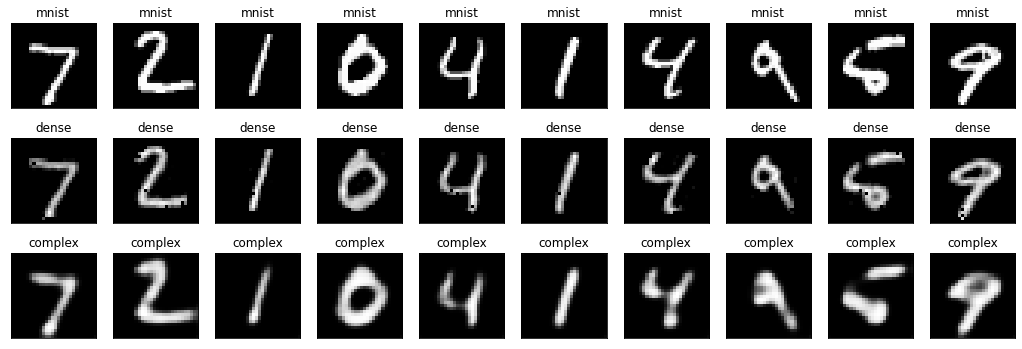

In [0]:
number = 10  # how many digits we will display
plt.figure(figsize=(18, 6))
for index in range(number):
    # display original
    ax = plt.subplot(3, number, index + 1)
    plt.imshow(np.squeeze(x_test[index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('mnist')

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + number)
    plt.imshow(np.squeeze(dense_autoencoder(x_test)[index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('dense')

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + number + number)
    plt.imshow(np.squeeze(cnn_complex_autoencoder(x_test)[index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('complex')

plt.show()

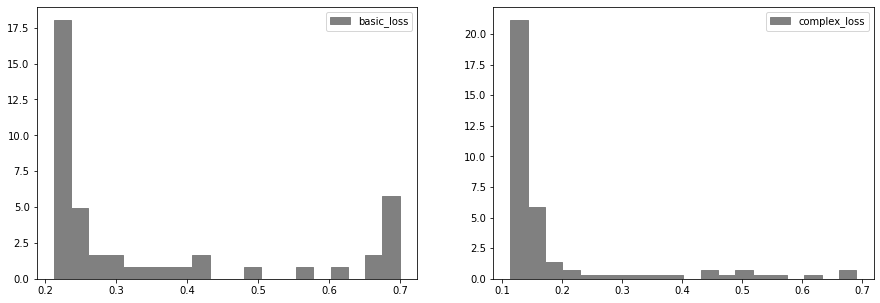

In [0]:
n_bins = 20
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(cnn_basic_autoencoder_history['loss'], n_bins, density=True, histtype='step', cumulative=False, label='basic_loss', color='grey', fill=True)
ax[0].legend()

ax[1].hist(cnn_complex_autoencoder_history['loss'], n_bins, density=True, histtype='step', cumulative=False, label='complex_loss', color='grey', fill=True)
ax[1].legend()

###**Testing**

In [0]:
print('alternative = two-sided')
print(sp.mannwhitneyu(cnn_basic_autoencoder_history['loss'], cnn_complex_autoencoder_history['loss'], alternative="two-sided"))

print('alternative = less')
print(sp.mannwhitneyu(cnn_basic_autoencoder_history['loss'], cnn_complex_autoencoder_history['loss'], alternative="less"))

print('alternative = greater')
print(sp.mannwhitneyu(cnn_basic_autoencoder_history['loss'], cnn_complex_autoencoder_history['loss'], alternative="greater"))

alternative = two-sided
MannwhitneyuResult(statistic=4403.0, pvalue=3.33104439574259e-14)
alternative = less
MannwhitneyuResult(statistic=4403.0, pvalue=0.9999999999999839)
alternative = greater
MannwhitneyuResult(statistic=4403.0, pvalue=1.665522197871295e-14)


###**Discussion**

- The dense autoencoder performed best. Perhaps this is because it has the most trainable parameters. This is fine for the small MNIST data but it may not scale well to larger images.


- The complex CNN outperformed the basic CNN. The complex CNN has approximately 10 times the number of trainable parameters. 


- We did a Mann-Whitney U test on the historical loss data from the basic and complex CNN. Why?
  - Histograms suggest that the historical loss is not normally distributed; therefore a t-test was inappropriate.
  - Both samples are independent; therefore a Wilcoxon signed-rank test was inappropriate.

  The results of the Mann-Whitney U test suggests that the loss of the basic and complex CNNs are distributed differently and that the loss of the complex CNN is lower than that of the basic CNN.

- Visually, the complex CNN and the dense autoencoder both perform well at image reconstruction even though the loss of the CNN is significantly higher. We used different loss functions, which may explain this, and it suggests that we can get good results using CNNs for significantly less trainiable parameters. 


# **Task 2:**

##**Preprocessing**

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

##**Dense, multi-layer model**

In [0]:
def build_dense(s, i, j, activation):
  # this function returns
  # a dense autoencoder

  encoder = keras.Sequential([
                              keras.layers.Flatten(input_shape = s),
                              keras.layers.Dense(i, activation = activation),
                              keras.layers.Dense(j, activation = activation)
  ])

  decoder = keras.Sequential([
                              keras.layers.Dense(j, activation = activation),
                              keras.layers.Dense(i, activation = activation),
                              keras.layers.Dense(s[0]*s[1], activation = activation),
                              keras.layers.Reshape(s)
  ])

  autoencoder = keras.Sequential([
                                  encoder,
                                  decoder
  ])

  encoder.summary()
  decoder.summary()
  autoencoder.summary()

  return autoencoder

  

In [0]:
dense_noise = build_dense((28, 28, 1), 64, 32, tf.nn.relu)

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
Total params: 52,320
Trainable params: 52,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                2112      
__________________________

##**CNN complex model**

In [0]:
def build_complex(s, i, j, activation):

  complex_encoder = keras.Sequential([
                                      tf.keras.layers.Conv2D(i, (4,4), activation = activation, padding='same', input_shape=s ),
                                      tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                      tf.keras.layers.Conv2D(j, (2,2), activation = activation, padding='same'),
                                      tf.keras.layers.MaxPooling2D((2,2), padding='same'),                                         
  ])

  complex_decoder = keras.Sequential([
                                      tf.keras.layers.Conv2D(j, (2,2), activation = activation, padding='same'),
                                      tf.keras.layers.UpSampling2D((2,2)),
                                      tf.keras.layers.Conv2D(i, (4,4), activation = activation, padding='same'),
                                      tf.keras.layers.UpSampling2D((2,2)),                                
                                      tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
  ])

  complex_autoencoder = keras.Sequential([
                                          complex_encoder,
                                          complex_decoder
                                          
  ])

  complex_encoder.summary()
  complex_decoder.summary()
  complex_autoencoder.summary()

  return complex_autoencoder

In [0]:
cnn_noise = build_complex((28, 28, 1), 64, 64, tf.nn.relu)

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 14, 14, 64)        16448     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 7, 7, 64)          0         
Total params: 17,536
Trainable params: 17,536
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 7, 7, 64)          16448     
__________________________

##**Training**

###**Compilation and training**

In [0]:
dense_noise.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
dense_noise_history = dense_noise.fit(x_train_noisy, x_train, batch_size=256, epochs=50, validation_data=(x_test_noisy, x_test), shuffle=True)

Epoch 1/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0682 - val_loss: 0.0578
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0548 - val_loss: 0.0521
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0505 - val_loss: 0.0490
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0481 - val_loss: 0.0471
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0465 - val_loss: 0.0455
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0451 - val_loss: 0.0446
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0443 - val_loss: 0.0438
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0432 - val_loss: 0.0427
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0425 - val_loss: 0.0420
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0419 - val_loss: 0.0416

In [0]:
cnn_noise.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
cnn_noise_history = cnn_noise.fit(x_train_noisy, x_train, batch_size=256, epochs=50, validation_data=(x_test_noisy, x_test), shuffle=True)

Epoch 1/50
235/235 [==============================] - 4s 17ms/step - loss: 0.6671 - val_loss: 0.6508
Epoch 2/50
235/235 [==============================] - 4s 17ms/step - loss: 0.6289 - val_loss: 0.6055
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 0.5749 - val_loss: 0.5461
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.5180 - val_loss: 0.5009
Epoch 5/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4879 - val_loss: 0.4860
Epoch 6/50
235/235 [==============================] - 4s 16ms/step - loss: 0.4785 - val_loss: 0.4806
Epoch 7/50
235/235 [==============================] - 4s 16ms/step - loss: 0.4735 - val_loss: 0.4758
Epoch 8/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4685 - val_loss: 0.4708
Epoch 9/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4636 - val_loss: 0.4657
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4585 - val_lo

### **Checkpoint**

In [0]:
path = '/content/drive/My Drive/cs6421_final_assignment/'

In [0]:
dense_noise.save(path + 'dense_noise')
cnn_noise.save(path + 'cnn_noise')

INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/dense_noise/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_noise/assets


In [0]:
with open(path + 'dense_noise_history', 'wb') as save:
  pickle.dump(dense_noise_history.history, save)

with open(path + 'cnn_noise_history', 'wb') as save:
  pickle.dump(cnn_noise_history.history, save)

In [0]:
dense_noise = keras.models.load_model(path + 'dense_noise', compile=False)
cnn_noise = keras.models.load_model(path + 'cnn_noise', compile=False)

In [0]:
dense_noise_pickle = open(path + 'dense_noise_history', 'rb')
cnn_noise_pickle = open(path + 'cnn_noise_history', 'rb')

dense_noise_history = pickle.load(dense_noise_pickle)
cnn_noise_history = pickle.load(cnn_noise_pickle)

dense_noise_pickle.close()
cnn_noise_pickle.close()

##**Results and Discussion**

### **Visualisation**

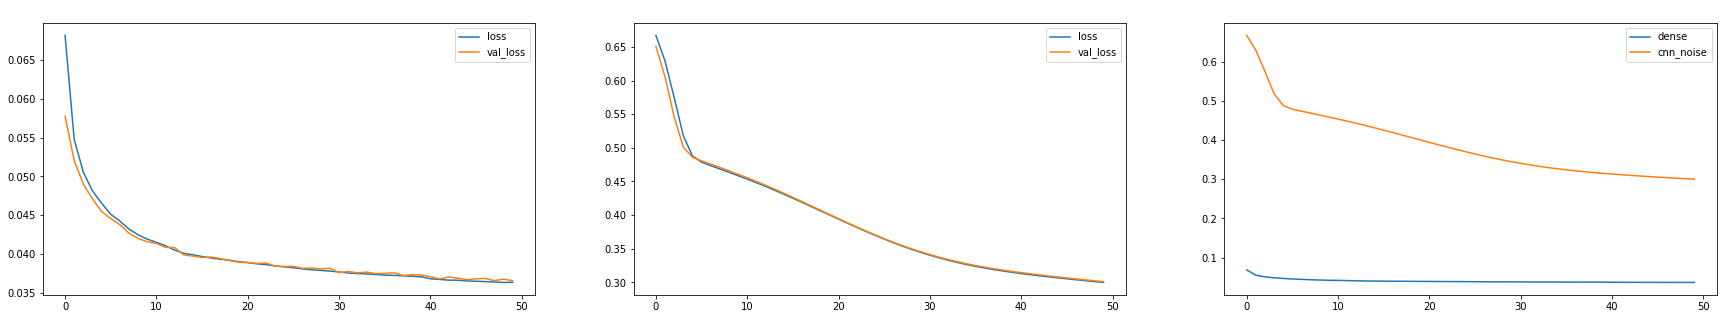

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax[0].plot(range(50), dense_noise_history['loss'], label = 'loss')
ax[0].plot(range(50), dense_noise_history['val_loss'], label = 'val_loss')
ax[0].set_title('dense_noise', color = 'white')
ax[0].legend()

ax[1].plot(range(50), cnn_noise_history['loss'], label = 'loss')
ax[1].plot(range(50), cnn_noise_history['val_loss'], label = 'val_loss')
ax[1].set_title('cnn_noise', color = 'white')
ax[1].legend()

ax[2].plot(range(50), dense_noise_history['loss'], label = 'dense')
ax[2].plot(range(50), cnn_noise_history['loss'], label = 'cnn_noise')
ax[2].set_title('Training Loss', color = 'white')
ax[2].legend()

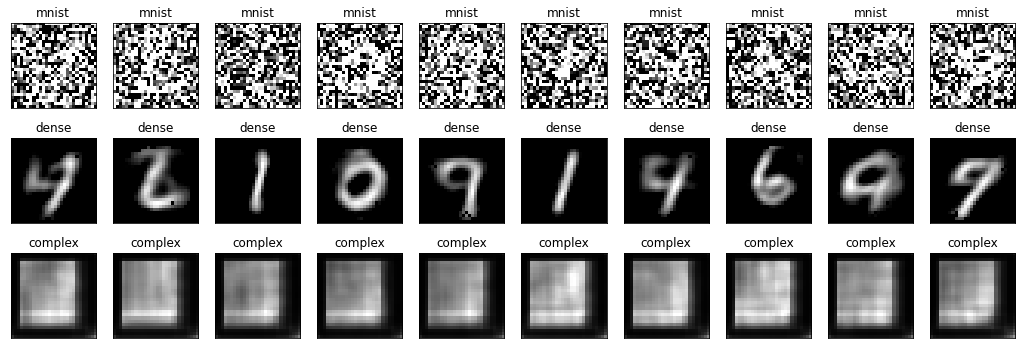

In [0]:
number = 10  # how many digits we will display
plt.figure(figsize=(18, 6))
for index in range(number):

    test = np.expand_dims(x_test_noisy[index], 0)


    # display original
    ax = plt.subplot(3, number, index + 1)
    plt.imshow(np.squeeze(x_test_noisy[index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('mnist')

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + number)
    plt.imshow(np.squeeze(dense_noise(test)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('dense')

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + number + number)
    plt.imshow(np.squeeze(cnn_noise(test)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('complex')

plt.show()

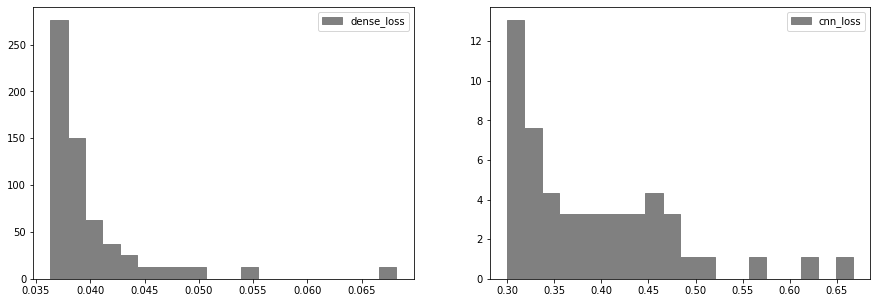

In [0]:
n_bins = 20
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(dense_noise_history['loss'], n_bins, density=True, histtype='step', cumulative=False, label='dense_loss', color='grey', fill=True)
ax[0].legend()

ax[1].hist(cnn_noise_history['loss'], n_bins, density=True, histtype='step', cumulative=False, label='cnn_loss', color='grey', fill=True)
ax[1].legend()

###**Testing**

In [0]:
print('alternative = two-sided')
print(sp.mannwhitneyu(dense_noise_history['loss'], cnn_noise_history['loss'], alternative="two-sided"))

print('alternative = less')
print(sp.mannwhitneyu(dense_noise_history['loss'], cnn_noise_history['loss'], alternative="less"))

print('alternative = greater')
print(sp.mannwhitneyu(dense_noise_history['loss'], cnn_noise_history['loss'], alternative="greater"))

alternative = two-sided
MannwhitneyuResult(statistic=0.0, pvalue=7.066071930388932e-18)
alternative = less
MannwhitneyuResult(statistic=0.0, pvalue=3.533035965194466e-18)
alternative = greater
MannwhitneyuResult(statistic=0.0, pvalue=1.0)


###**Discussion**

We defined new dense and convolutional networks for this task. Both models were trained for 50 epochs, batch-size 256, similar number of trainable parameters. 

We performed the same tests and visualisations as those in task one. Bizzarely we, again, found that the dense network outperformed the CNN; which is not what we expected. 

We have used different optimisation and loss functions. A better approach would be to set everything else equal and simply compare the efficacy of the architecture.

With regards to the loss curves. The dense model trained better. The shape of this loss curve is optimal. The CNN model has not trained as well; perhaps some adjustment to the learning rate or optimisation algorithm would improve this.

The loss curve of the CNN has an unusual elbow at approximately the fifth epoch. The training rate decreases significantly. Perhaps the data are insufficient.

## **Further Experiments**

### **Training**

####**Training and compilation**

In [0]:
dense_noise_2 = build_dense((28,28,1), 128, 64, tf.nn.leaky_relu)

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 128)               8320      
________________________

In [0]:
cnn_noise_2 = build_complex((28,28,1), 128, 64, tf.nn.leaky_relu)

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 28, 28, 128)       2176      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 7, 7, 64)          0         
Total params: 35,008
Trainable params: 35,008
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 7, 7, 64)          16448     
________________________

In [0]:
dense_noise_2.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
dense_noise_2_history = dense_noise_2.fit(x_train_noisy, x_train, batch_size=256, epochs=100, validation_data=(x_test_noisy, x_test), shuffle=True)

Epoch 1/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0596 - val_loss: 0.0492
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0456 - val_loss: 0.0427
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0419 - val_loss: 0.0411
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0401 - val_loss: 0.0393
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0387 - val_loss: 0.0383
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0379 - val_loss: 0.0375
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0371 - val_loss: 0.0370
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0365 - val_loss: 0.0367
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0359 - val_loss: 0.0358
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0355 - val_lo

In [0]:
cnn_noise_2.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
cnn_noise_2_history = cnn_noise_2.fit(x_train_noisy, x_train, batch_size=128, epochs=100, validation_data=(x_test_noisy, x_test), shuffle=True)

Epoch 1/100
469/469 [==============================] - 8s 16ms/step - loss: 0.6583 - val_loss: 0.6038
Epoch 2/100
469/469 [==============================] - 7s 16ms/step - loss: 0.5342 - val_loss: 0.4954
Epoch 3/100
469/469 [==============================] - 7s 16ms/step - loss: 0.4851 - val_loss: 0.4849
Epoch 4/100
469/469 [==============================] - 8s 16ms/step - loss: 0.4765 - val_loss: 0.4766
Epoch 5/100
469/469 [==============================] - 8s 16ms/step - loss: 0.4682 - val_loss: 0.4680
Epoch 6/100
469/469 [==============================] - 8s 16ms/step - loss: 0.4593 - val_loss: 0.4586
Epoch 7/100
469/469 [==============================] - 8s 16ms/step - loss: 0.4496 - val_loss: 0.4485
Epoch 8/100
469/469 [==============================] - 8s 16ms/step - loss: 0.4392 - val_loss: 0.4375
Epoch 9/100
469/469 [==============================] - 8s 16ms/step - loss: 0.4280 - val_loss: 0.4259
Epoch 10/100
469/469 [==============================] - 8s 16ms/step - loss: 0.416

#### **Checkpoint**

In [0]:
path = '/content/drive/My Drive/cs6421_final_assignment/'

In [0]:
dense_noise_2.save(path + 'dense_noise_2')
cnn_noise_2.save(path + 'cnn_noise_2')

INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/dense_noise_2/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_noise_2/assets


In [0]:
with open(path + 'dense_noise_2_history', 'wb') as save:
  pickle.dump(dense_noise_2_history.history, save)

with open(path + 'cnn_noise_2_history', 'wb') as save:
  pickle.dump(cnn_noise_2_history.history, save)

In [0]:
dense_noise_2 = keras.models.load_model(path + 'dense_noise_2')
cnn_noise_2 = keras.models.load_model(path + 'cnn_noise_2')

In [0]:
dense_noise_2_pickle = open(path + 'dense_noise_2_history', 'rb')
cnn_noise_2_pickle = open(path + 'cnn_noise_2_history', 'rb')

dense_noise_2_history = pickle.load(dense_noise_2_pickle)
cnn_noise_2_history = pickle.load(cnn_noise_2_pickle)

dense_noise_2_pickle.close()
cnn_noise_2_pickle.close()

###**Visualisation**

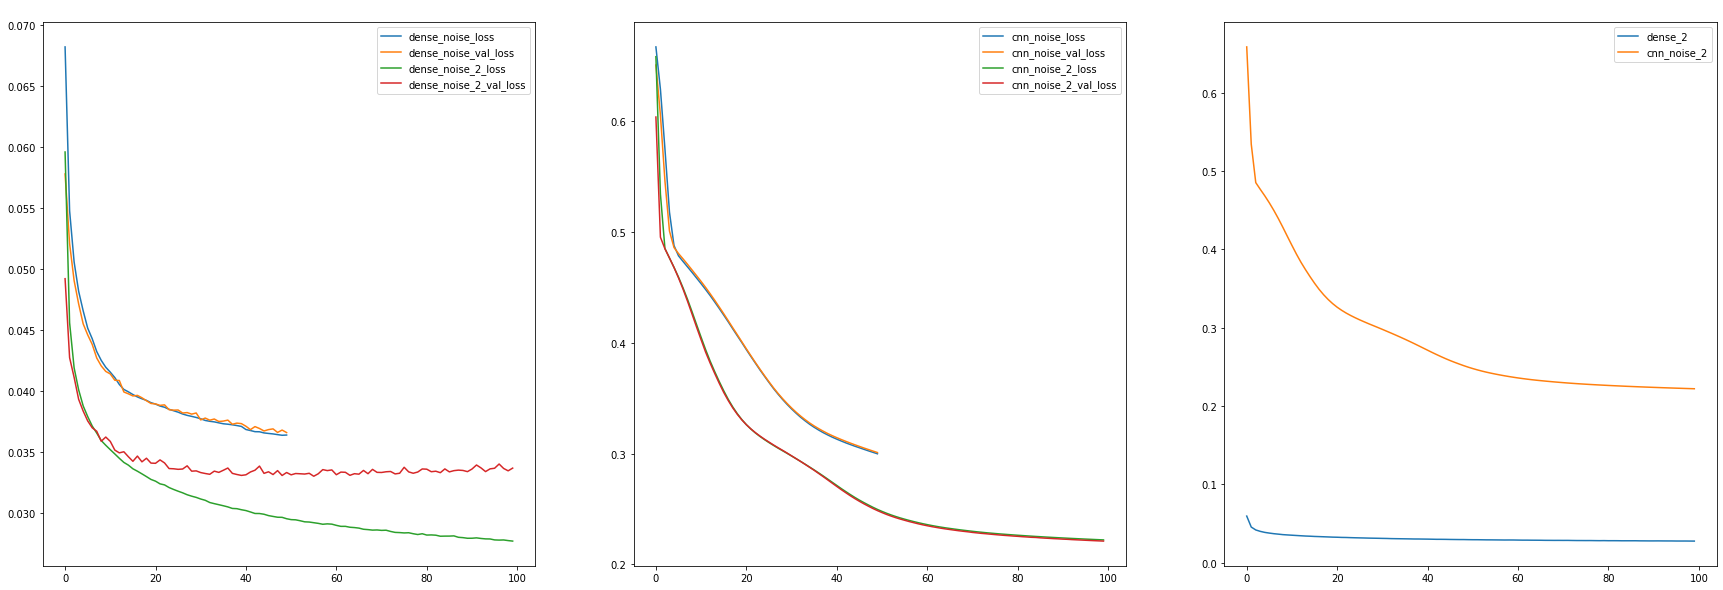

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].plot(range(50), dense_noise_history['loss'], label = 'dense_noise_loss')
ax[0].plot(range(50), dense_noise_history['val_loss'], label = 'dense_noise_val_loss')
ax[0].plot(range(100), dense_noise_2_history['loss'], label = 'dense_noise_2_loss')
ax[0].plot(range(100), dense_noise_2_history['val_loss'], label = 'dense_noise_2_val_loss')
ax[0].set_title('dense_noise || dense_noise_2', color = 'white')
ax[0].legend()

ax[1].plot(range(50), cnn_noise_history['loss'], label = 'cnn_noise_loss')
ax[1].plot(range(50), cnn_noise_history['val_loss'], label = 'cnn_noise_val_loss')
ax[1].plot(range(100), cnn_noise_2_history['loss'], label = 'cnn_noise_2_loss')
ax[1].plot(range(100), cnn_noise_2_history['val_loss'], label = 'cnn_noise_2_val_loss')
ax[1].set_title('cnn_noise || cnn_noise_2', color = 'white')
ax[1].legend()

ax[2].plot(range(100), dense_noise_2_history['loss'], label = 'dense_2')
ax[2].plot(range(100), cnn_noise_2_history['loss'], label = 'cnn_noise_2')
ax[2].set_title('Training Loss', color = 'white')
ax[2].legend()

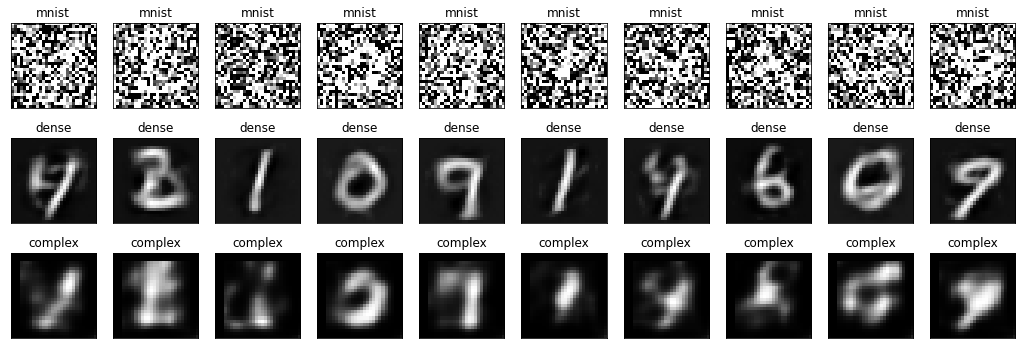

In [0]:
number = 10  # how many digits we will display
plt.figure(figsize=(18, 6))
for index in range(number):

    test = np.expand_dims(x_test_noisy[index], 0)

    # display original
    ax = plt.subplot(3, number, index + 1)
    plt.imshow(np.squeeze(x_test_noisy[index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('mnist')

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + number)
    plt.imshow(np.squeeze(dense_noise_2(test)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('dense')

    # display reconstruction
    ax = plt.subplot(3, number, index + 1 + number + number)
    plt.imshow(np.squeeze(cnn_noise_2(test)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('complex')

plt.show()

###**Testing**

In [0]:
print('alternative = two-sided')
print(sp.mannwhitneyu(dense_noise_history['loss'], dense_noise_2_history['loss'], alternative="two-sided"))

print('alternative = less')
print(sp.mannwhitneyu(dense_noise_history['loss'], dense_noise_2_history['loss'], alternative="less"))

print('alternative = greater')
print(sp.mannwhitneyu(dense_noise_history['loss'], dense_noise_2_history['loss'], alternative="greater"))

alternative = two-sided
MannwhitneyuResult(statistic=4764.0, pvalue=1.8139357820814936e-19)
alternative = less
MannwhitneyuResult(statistic=4764.0, pvalue=1.0)
alternative = greater
MannwhitneyuResult(statistic=4764.0, pvalue=9.069678910407468e-20)


In [0]:
print('alternative = two-sided')
print(sp.mannwhitneyu(cnn_noise_history['loss'], cnn_noise_2_history['loss'], alternative="two-sided"))

print('alternative = less')
print(sp.mannwhitneyu(cnn_noise_history['loss'], cnn_noise_2_history['loss'], alternative="less"))

print('alternative = greater')
print(sp.mannwhitneyu(cnn_noise_history['loss'], cnn_noise_2_history['loss'], alternative="greater"))

alternative = two-sided
MannwhitneyuResult(statistic=4266.0, pvalue=1.942128999691417e-12)
alternative = less
MannwhitneyuResult(statistic=4266.0, pvalue=0.9999999999990563)
alternative = greater
MannwhitneyuResult(statistic=4266.0, pvalue=9.710644998457085e-13)


##**Discussion**

We defined some new models to improve our denoising.

- We observed evidence of overfitting in our dense network which is evidenced by the divergence of the training and validation loss. Visually, there is a noticable difference in perfromance.
- We noticed an improvement in our CNN model. Maybe adding more complexity would further improve performace. Maybe not. At this point we're starting to think that CNNs perform better on larger inputs. The MNIST data are quite small.
- The small proportion of genuine improvement in the dense model (before the training and validation loss  curves diverge) may be due to the choice of a leaky relu activation funtion. This suggests that some proportion of the original dense network was subject to the dyng relu problem.

# **Task 3:**

##**Preprocessing**

In [0]:
path = '/content/drive/My Drive/cs6421_datasets/'

tra_dir = path + 'train/'
tcl_dir = path + 'train_cleaned/'
tes_dir = path + 'test/'

train_images = sorted(os.listdir(tra_dir))
train_labels = sorted(os.listdir(tcl_dir))
test_images = sorted(os.listdir(tes_dir))

X = []
Y = []
Z = []

for img in train_images:
  print(f'Processing {img}')
  img = load_img(tra_dir + img, color_mode='grayscale', target_size = (420, 540))
  img = img_to_array(img).astype('float32') / 255.0
  X.append(img)
  
for img in train_labels:
  print(f'Processing {img}')
  img = load_img(tcl_dir + img, color_mode='grayscale', target_size = (420, 540))
  img = img_to_array(img).astype('float32') / 255.0
  Y.append(img)

for img in test_images:
  print(f'Processing {img}')
  img = load_img(tes_dir + img, color_mode='grayscale', target_size = (420, 540))
  img = img_to_array(img).astype('float32') / 255.0
  Z.append(img)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)

Processing 101.png
Processing 102.png
Processing 104.png
Processing 105.png
Processing 107.png
Processing 108.png
Processing 11.png
Processing 110.png
Processing 111.png
Processing 113.png
Processing 114.png
Processing 116.png
Processing 117.png
Processing 119.png
Processing 12.png
Processing 120.png
Processing 122.png
Processing 123.png
Processing 125.png
Processing 126.png
Processing 128.png
Processing 129.png
Processing 131.png
Processing 132.png
Processing 134.png
Processing 135.png
Processing 137.png
Processing 138.png
Processing 14.png
Processing 140.png
Processing 141.png
Processing 143.png
Processing 144.png
Processing 146.png
Processing 147.png
Processing 149.png
Processing 15.png
Processing 150.png
Processing 152.png
Processing 153.png
Processing 155.png
Processing 156.png
Processing 158.png
Processing 159.png
Processing 161.png
Processing 162.png
Processing 164.png
Processing 165.png
Processing 167.png
Processing 168.png
Processing 17.png
Processing 170.png
Processing 171.pn

In [0]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

##**Dense, multi layer model**

In [0]:
dense_text = build_dense((420, 540, 1), 128, 64, tf.nn.leaky_relu)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 226800)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               29030528  
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
Total params: 29,038,784
Trainable params: 29,038,784
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
____________________

##**CNN basic model**

In [0]:
cnn_basic_text = build_complex((420, 540, 1), 32, 12, tf.nn.relu)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 420, 540, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 270, 12)      1548      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 105, 135, 12)      0         
Total params: 2,092
Trainable params: 2,092
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 105, 135, 12)      588       
______________________________

##**CNN complex model one**

In [0]:
cnn_complex_text_one = keras.Sequential([
                                        # encoder part
                                        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(420, 540, 1)),
                                        tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                      
                                        # decoder part
                                        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
                                        tf.keras.layers.UpSampling2D((2,2)),                                

                                        tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'),
])

cnn_complex_text_one.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 420, 540, 128)     1280      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 210, 270, 128)     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 210, 270, 128)     147584    
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 420, 540, 128)     0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 420, 540, 1)       1153      
Total params: 150,017
Trainable params: 150,017
Non-trainable params: 0
_________________________________________________________________


##**CNN complex model two**

In [0]:
cnn_complex_text_two = keras.Sequential([
                                        # encoder part
                                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(420, 540, 1)),
                                        tf.keras.layers.MaxPooling2D((3, 3), padding='same'),

                                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

                                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

                                        # dense part
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(256, activation= tf.nn.leaky_relu),
                                        tf.keras.layers.Dense(100800, activation= tf.nn.leaky_relu),
                                        tf.keras.layers.Reshape((35, 45, 64)),

                                        # decoder part
                                        tf.keras.layers.UpSampling2D((2, 2)),                                
                                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),

                                        tf.keras.layers.UpSampling2D((2, 2)),                                
                                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

                                        tf.keras.layers.UpSampling2D((3, 3)),
                                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

                                        #sigmoid part
                                        tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'),

])

cnn_complex_text_two.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 420, 540, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 140, 180, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 140, 180, 32)      9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 70, 90, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 70, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 35, 45, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 100800)          

##**Training**

###**Compilation and training**

In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='auto', restore_best_weights=True)

In [0]:
dense_text.compile(optimizer='adam', loss=root_mean_squared_error)

In [0]:
cnn_basic_text.compile(optimizer='adadelta', loss=root_mean_squared_error)

In [0]:
cnn_complex_text_one.compile(optimizer='adam', loss=root_mean_squared_error)

In [0]:
cnn_complex_text_two.compile(optimizer='adadelta', loss=root_mean_squared_error)

In [0]:
dense_text_history = dense_text.fit(X_train,
                                    Y_train,
                                    epochs=100,
                                    batch_size=8,
                                    validation_data=(X_valid, Y_valid),
                                    callbacks=[early_stop]
                                    )

Epoch 1/100
17/17 [==============================] - 1s 51ms/step - loss: 0.7629 - val_loss: 0.3809
Epoch 2/100
17/17 [==============================] - 1s 41ms/step - loss: 0.3121 - val_loss: 0.3126
Epoch 3/100
17/17 [==============================] - 1s 38ms/step - loss: 0.2920 - val_loss: 0.3077
Epoch 4/100
17/17 [==============================] - 1s 37ms/step - loss: 0.2693 - val_loss: 0.2677
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 0.2601 - val_loss: 0.2612
Epoch 6/100
17/17 [==============================] - 1s 37ms/step - loss: 0.2530 - val_loss: 0.2586
Epoch 7/100
17/17 [==============================] - 1s 37ms/step - loss: 0.2412 - val_loss: 0.2439
Epoch 8/100
17/17 [==============================] - 1s 38ms/step - loss: 0.2355 - val_loss: 0.2391
Epoch 9/100
17/17 [==============================] - 1s 30ms/step - loss: 0.2306 - val_loss: 0.2416
Epoch 10/100
17/17 [==============================] - 1s 31ms/step - loss: 0.2362 - val_loss: 0.2439

In [0]:
cnn_basic_text_history = cnn_basic_text.fit(X_train,
                                    Y_train,
                                    epochs=100,
                                    batch_size=8,
                                    validation_data=(X_valid, Y_valid),
                                    callbacks=[early_stop]
                                    )

Epoch 1/100
17/17 [==============================] - 2s 124ms/step - loss: 0.4686 - val_loss: 0.4663
Epoch 2/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4681 - val_loss: 0.4662
Epoch 3/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4681 - val_loss: 0.4661
Epoch 4/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4680 - val_loss: 0.4659
Epoch 5/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4686 - val_loss: 0.4658
Epoch 6/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4679 - val_loss: 0.4657
Epoch 7/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4679 - val_loss: 0.4655
Epoch 8/100
17/17 [==============================] - 2s 100ms/step - loss: 0.4676 - val_loss: 0.4654
Epoch 9/100
17/17 [==============================] - 2s 99ms/step - loss: 0.4673 - val_loss: 0.4652
Epoch 10/100
17/17 [==============================] - 2s 98ms/step - loss: 0.4674 - val_loss: 0.46

In [0]:
cnn_complex_text_one_history = cnn_complex_text_one.fit(X_train,
                                    Y_train,
                                    epochs=100,
                                    batch_size=8,
                                    validation_data=(X_valid, Y_valid),
                                    callbacks=[early_stop]
                                    )

Epoch 1/100
17/17 [==============================] - 7s 383ms/step - loss: 0.2859 - val_loss: 0.2500
Epoch 2/100
17/17 [==============================] - 6s 340ms/step - loss: 0.2269 - val_loss: 0.1902
Epoch 3/100
17/17 [==============================] - 6s 343ms/step - loss: 0.1493 - val_loss: 0.1290
Epoch 4/100
17/17 [==============================] - 6s 345ms/step - loss: 0.1157 - val_loss: 0.1057
Epoch 5/100
17/17 [==============================] - 6s 343ms/step - loss: 0.1001 - val_loss: 0.1012
Epoch 6/100
17/17 [==============================] - 6s 344ms/step - loss: 0.0933 - val_loss: 0.0900
Epoch 7/100
17/17 [==============================] - 6s 346ms/step - loss: 0.0870 - val_loss: 0.0865
Epoch 8/100
17/17 [==============================] - 6s 346ms/step - loss: 0.0808 - val_loss: 0.0852
Epoch 9/100
17/17 [==============================] - 6s 347ms/step - loss: 0.0770 - val_loss: 0.0813
Epoch 10/100
17/17 [==============================] - 6s 350ms/step - loss: 0.0735 - val_lo

In [0]:
cnn_complex_text_two_history = cnn_complex_text_two.fit(X_train,
                                    Y_train,
                                    epochs=100,
                                    batch_size=8,
                                    validation_data=(X_valid, Y_valid),
                                    callbacks=[early_stop]
                                    )

Epoch 1/100
17/17 [==============================] - 4s 232ms/step - loss: 0.4722 - val_loss: 0.4697
Epoch 2/100
17/17 [==============================] - 3s 173ms/step - loss: 0.4721 - val_loss: 0.4697
Epoch 3/100
17/17 [==============================] - 3s 171ms/step - loss: 0.4724 - val_loss: 0.4697
Epoch 4/100
17/17 [==============================] - 3s 181ms/step - loss: 0.4717 - val_loss: 0.4696
Epoch 5/100
17/17 [==============================] - 3s 174ms/step - loss: 0.4721 - val_loss: 0.4696
Epoch 6/100
17/17 [==============================] - 3s 172ms/step - loss: 0.4719 - val_loss: 0.4695
Epoch 7/100
17/17 [==============================] - 3s 180ms/step - loss: 0.4720 - val_loss: 0.4695
Epoch 8/100
17/17 [==============================] - 3s 174ms/step - loss: 0.4719 - val_loss: 0.4694
Epoch 9/100
17/17 [==============================] - 3s 173ms/step - loss: 0.4719 - val_loss: 0.4694
Epoch 10/100
17/17 [==============================] - 3s 180ms/step - loss: 0.4717 - val_lo

### **Checkpoint**

In [0]:
path = '/content/drive/My Drive/cs6421_final_assignment/'

In [0]:
models      = [dense_text, cnn_basic_text, cnn_complex_text_one, cnn_complex_text_two]
models_path = ['dense_text', 'cnn_basic_text', 'cnn_complex_text_one', 'cnn_complex_text_two']

models_hist = [dense_text_history.history, cnn_basic_text_history.history, cnn_complex_text_one_history.history, cnn_complex_text_two_history.history]
models_hist_path = ['dense_text_history', 'cnn_basic_text_history', 'cnn_complex_text_one_history', 'cnn_complex_text_two_history']

In [0]:
for i in range(len(models)):
  
  models[i].save(path + models_path[i])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/dense_text/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_basic_text/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_complex_text_one/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/cs6421_final_assignment/cnn_complex_text_two/assets


In [0]:
for i in range(len(models_hist)):

  with open(path + models_hist_path[i], 'wb') as save:
    pickle.dump(models_hist[i], save)


In [0]:
models      = []
models_path = ['dense_text', 'cnn_basic_text', 'cnn_complex_text_one', 'cnn_complex_text_two']

models_hist = []
models_hist_path = ['dense_text_history', 'cnn_basic_text_history', 'cnn_complex_text_one_history', 'cnn_complex_text_two_history']

In [0]:
for i in range(len(models_path)):
  
  models.append(keras.models.load_model(path + models_path[i], compile=False))

In [0]:
for i in range(len(models_hist_path)):
  
  with open(path + models_hist_path[i], 'rb') as load:
    models_hist.append(pickle.load(load))

##**Results and Discussion**

###**Visualisation**

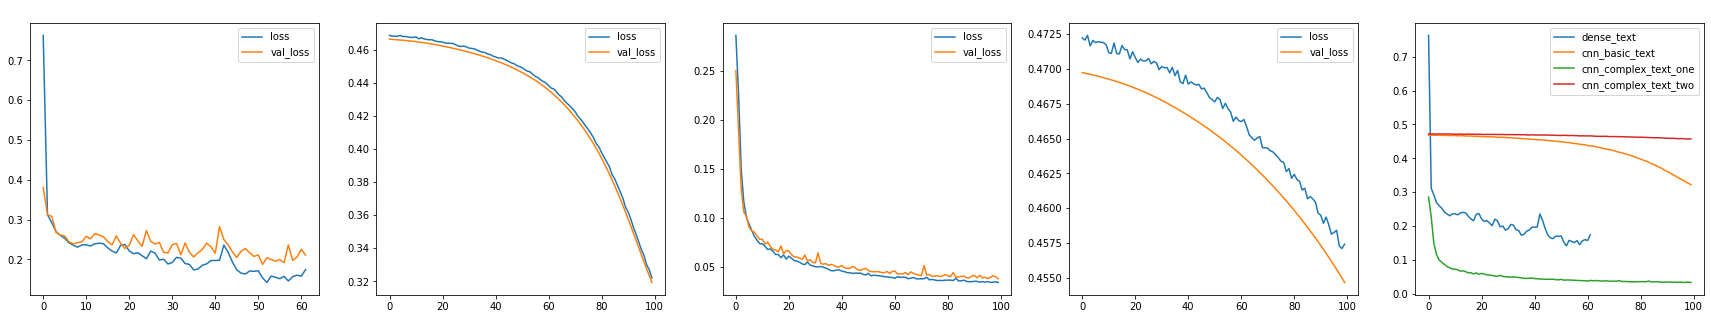

In [0]:
fig, ax = plt.subplots(1, 5, figsize=(30,5))

for i in range(4):
  ax[i].plot(range(len(models_hist[i]['loss'])), models_hist[i]['loss'], label = 'loss')
  ax[i].plot(range(len(models_hist[i]['val_loss'])),models_hist[i]['val_loss'],  label = 'val_loss')
  ax[i].set_title(models_path[i], color = 'white')
  ax[i].legend()

ax[4].plot(range(len(models_hist[0]['loss'])), models_hist[0]['loss'], label = models_path[0])
ax[4].plot(range(len(models_hist[1]['loss'])), models_hist[1]['loss'], label = models_path[1])
ax[4].plot(range(len(models_hist[2]['loss'])), models_hist[2]['loss'], label = models_path[2])
ax[4].plot(range(len(models_hist[3]['loss'])), models_hist[3]['loss'], label = models_path[3])
ax[4].set_title('Training Loss', color = 'white')
ax[4].legend()

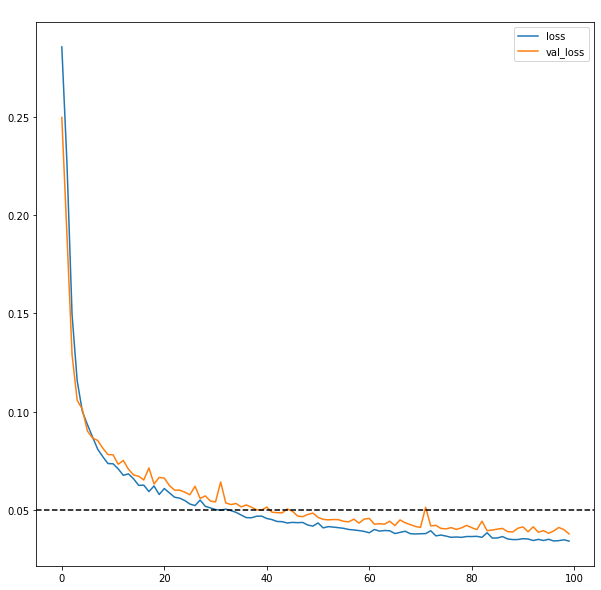

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(range(len(models_hist[2]['loss'])), models_hist[2]['loss'], label = 'loss')
ax.plot(range(len(models_hist[2]['val_loss'])),models_hist[2]['val_loss'],  label = 'val_loss')
ax.axhline(y=0.05, c='k', ls='--')
ax.set_title(models_path[2], color = 'white')
ax.legend()

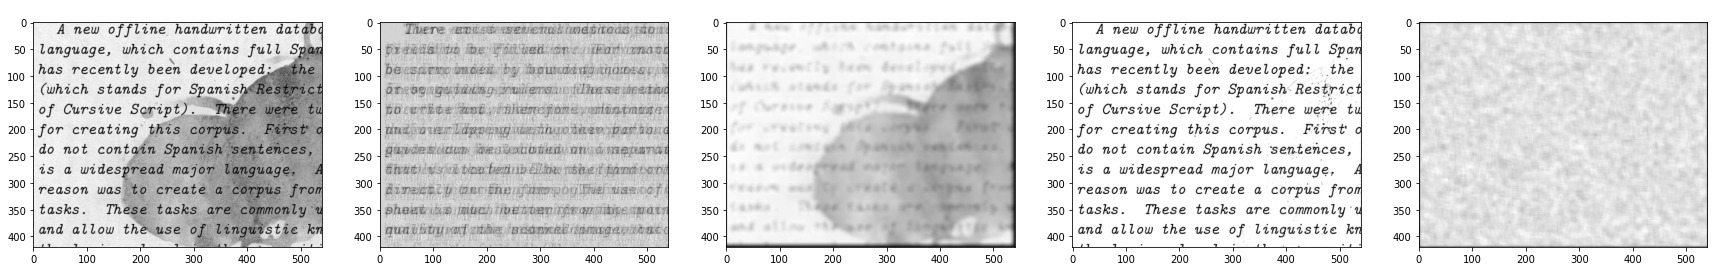

In [0]:
n = 9
test = np.expand_dims(Z[n], 0)

fig, ax = plt.subplots(1, 5, figsize=(30,5))
ax[0].imshow(np.squeeze(Z[n]), cmap = 'gray')

for i in range(len(models)):
  pred = models[i](test)
  ax[i+1].imshow(np.squeeze(pred), cmap='gray')
  ax[i+1].set_title(models_path[i], color = 'white')

###**Discusson**

- The loss curve of the dense model suggests that the learning rate is sub-optimal. The model jumps around, unable to reach an optimal state.

- Complex CNN one demonstrates an almost ideal training. Settling on a loss below 0.05. It is significantly simpler that complex CNN two. Maybe the complexity of the model should match the complexity of the data; possibly explaining why the dense model also performed better on the MNIST data-set.

- Complex CNN two demonstrates characteristic underfitting. The complexity of the data far underreaches the complexity of the model.

- The loss curves of the basic CNN and complex CNN two suggest that both models could benefit from further training. The loss is still decreasing at the end of training. 

# **Final Thoughts**

An interesting experiment in transfer learning and autoencoders would be as follows:

- Train a dense encoder to reduce the standard MNIST handwritten digits down to their latent representation.
- From this latent space, train a dense decoder to bring the MNIST dataset back up to (28,28,1)
- Repeat for another dense encoder/decoder (of the same specification) for the noisy MNIST digits.
- Test the performance when the encoder that has been trained on the noisy data is paired with the decoder that has been trained on the original data.
    - My theory is that the noisy and non-noisy encoder will reduce the input data down to the same (or sufficiently similar) latent representation. Thus allowing either decoder to restore the data.
